# Sample Interpolation Project

## Introduction

This notebook demonstrates sample interpolation techniques for digital signal processing. We will:

1. Generate test signals
2. Downsample the signals (reduce sample rate)
3. Implement various interpolation methods manually:
   - Nearest neighbor interpolation
   - Linear interpolation
   - Cubic interpolation
4. Compare our implementations with standard library functions
5. Analyze the results in both time and frequency domains

The project aims to fulfill the requirements of the MPC-CSI project assignment.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
import time

# Set up nice plots
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2

## 1. Signal Generation

First, let's create functions to generate test signals with different characteristics.

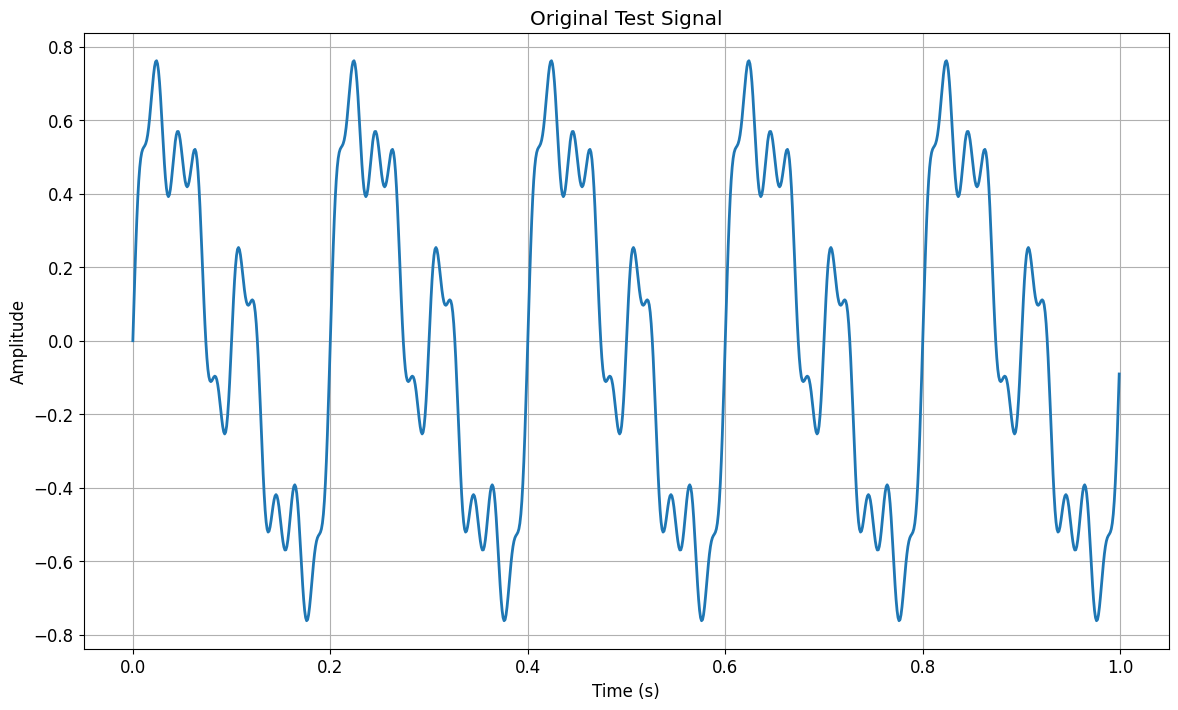

Signal duration: 1.00 seconds
Sampling rate: 1000.0 Hz
Number of samples: 1000


In [2]:
def generate_multisin_signal(sampling_rate=1000, duration=1.0):
    """
    Generate a test signal with multiple frequency components.
    
    Parameters:
    -----------
    sampling_rate : int
        Sampling rate in Hz
    duration : float
        Duration of the signal in seconds
        
    Returns:
    --------
    t : ndarray
        Time vector
    x : ndarray
        Signal values
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    
    # Create a signal with multiple frequency components
    x = 0.5 * np.sin(2 * np.pi * 5 * t)  # 5 Hz component
    x += 0.3 * np.sin(2 * np.pi * 10 * t)  # 10 Hz component
    x += 0.2 * np.sin(2 * np.pi * 20 * t)  # 20 Hz component
    x += 0.1 * np.sin(2 * np.pi * 50 * t)  # 50 Hz component
    
    return t, x

def generate_signal_library():
    """
    Generate a library of test signals with different characteristics.
    
    Returns:
    --------
    signals : dict
        Dictionary of test signals
    """
    # Time vector
    t = np.linspace(0, 1, 1000, endpoint=False)
    
    signals = {
        'Sine Wave': {
            't': t,
            'x': np.sin(2 * np.pi * 10 * t)
        },
        'Square Wave': {
            't': t,
            'x': signal.square(2 * np.pi * 5 * t)
        },
        'Sawtooth Wave': {
            't': t,
            'x': signal.sawtooth(2 * np.pi * 5 * t)
        },
        'Chirp': {
            't': t,
            'x': signal.chirp(t, f0=5, f1=50, t1=1, method='linear')
        },
        'Step Function': {
            't': t,
            'x': np.heaviside(t - 0.5, 0.5)
        }
    }
    
    return signals

# Generate our primary test signal
t_original, x_original = generate_multisin_signal()

# Plot the original signal
plt.figure()
plt.plot(t_original, x_original)
plt.title('Original Test Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Display signal information
print(f"Signal duration: {t_original[-1]:.2f} seconds")
print(f"Sampling rate: {1/(t_original[1] - t_original[0]):.1f} Hz")
print(f"Number of samples: {len(t_original)}")

## 2. Downsampling

Now, let's implement a function to downsample our signals. Downsampling reduces the sampling rate by keeping only every nth sample.

Downsampling factor: 2
  Original samples: 1000
  Downsampled samples: 500
  New sampling rate: 500.0 Hz
  Nyquist frequency: 250.0 Hz

Downsampling factor: 5
  Original samples: 1000
  Downsampled samples: 200
  New sampling rate: 200.0 Hz
  Nyquist frequency: 100.0 Hz

Downsampling factor: 10
  Original samples: 1000
  Downsampled samples: 100
  New sampling rate: 100.0 Hz
  Nyquist frequency: 50.0 Hz



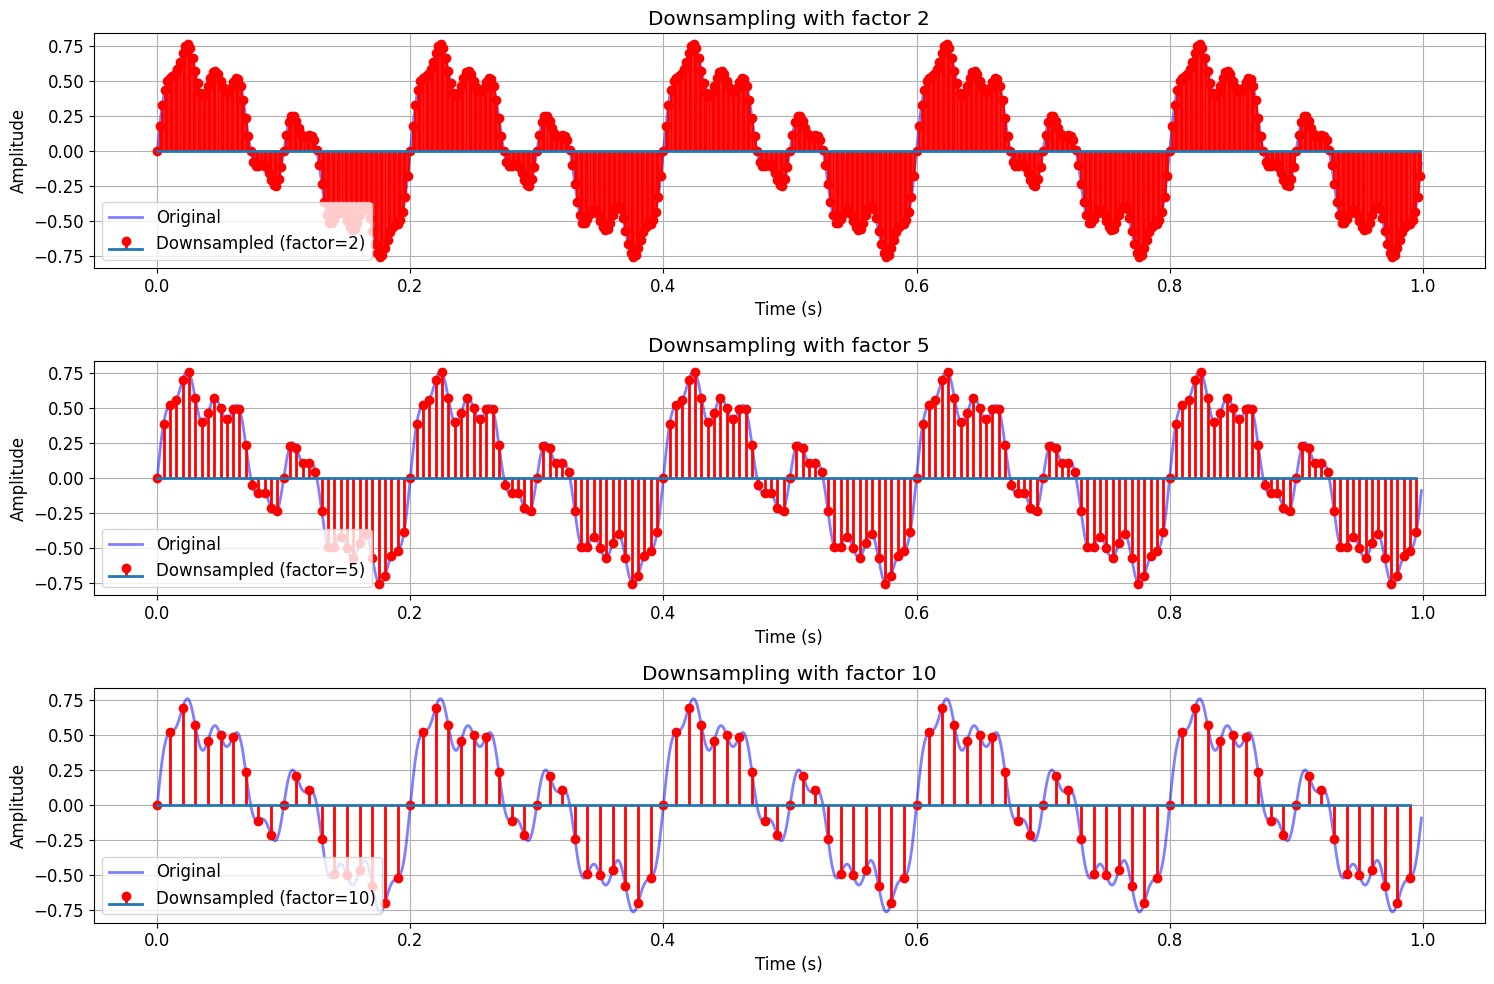

Using downsampling factor 5 for further analysis.


In [3]:
def downsample_signal(t, x, factor):
    """
    Manually downsample a signal by a given factor.
    
    Parameters:
    -----------
    t : ndarray
        Time vector of the original signal
    x : ndarray
        Original signal values
    factor : int
        Downsampling factor (e.g., 2 means taking every 2nd sample)
        
    Returns:
    --------
    t_down : ndarray
        Downsampled time vector
    x_down : ndarray
        Downsampled signal values
    """
    t_down = t[::factor]
    x_down = x[::factor]
    
    return t_down, x_down

# Demonstrate downsampling with different factors
downsampling_factors = [2, 5, 10]

plt.figure(figsize=(15, 10))
for i, factor in enumerate(downsampling_factors):
    t_down, x_down = downsample_signal(t_original, x_original, factor)
    
    plt.subplot(len(downsampling_factors), 1, i+1)
    plt.plot(t_original, x_original, 'b-', alpha=0.5, label='Original')
    plt.stem(t_down, x_down, 'r', markerfmt='ro', basefmt='', label=f'Downsampled (factor={factor})')
    plt.title(f'Downsampling with factor {factor}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    # Calculate and display statistics
    original_fs = 1/(t_original[1] - t_original[0])
    downsampled_fs = 1/(t_down[1] - t_down[0])
    nyquist_freq = downsampled_fs / 2
    
    print(f"Downsampling factor: {factor}")
    print(f"  Original samples: {len(t_original)}")
    print(f"  Downsampled samples: {len(t_down)}")
    print(f"  New sampling rate: {downsampled_fs:.1f} Hz")
    print(f"  Nyquist frequency: {nyquist_freq:.1f} Hz")
    print()

plt.tight_layout()
plt.show()

# Choose one downsampling factor for further analysis
chosen_factor = 5
t_down, x_down = downsample_signal(t_original, x_original, chosen_factor)
print(f"Using downsampling factor {chosen_factor} for further analysis.")

## 3. Manual Interpolation Methods

Now, let's implement various interpolation methods from scratch.

In [4]:
def nearest_neighbor_interpolation(t_down, x_down, t_target):
    """
    Manually implement nearest neighbor interpolation.
    
    Parameters:
    -----------
    t_down : ndarray
        Time vector of the downsampled signal
    x_down : ndarray
        Downsampled signal values
    t_target : ndarray
        Target time vector for interpolation
        
    Returns:
    --------
    x_interp : ndarray
        Interpolated signal values
    """
    x_interp = np.zeros_like(t_target)
    
    for i, t in enumerate(t_target):
        # Find the index of the closest point in t_down
        idx = np.argmin(np.abs(t_down - t))
        x_interp[i] = x_down[idx]
    
    return x_interp

def linear_interpolation(t_down, x_down, t_target):
    """
    Manually implement linear interpolation.
    
    Parameters:
    -----------
    t_down : ndarray
        Time vector of the downsampled signal
    x_down : ndarray
        Downsampled signal values
    t_target : ndarray
        Target time vector for interpolation
        
    Returns:
    --------
    x_interp : ndarray
        Interpolated signal values
    """
    x_interp = np.zeros_like(t_target)
    
    for i, t in enumerate(t_target):
        # If t is outside the range of t_down, use the edge values
        if t <= t_down[0]:
            x_interp[i] = x_down[0]
            continue
        elif t >= t_down[-1]:
            x_interp[i] = x_down[-1]
            continue
        
        # Find the indices of the two surrounding points
        idx_after = np.where(t_down >= t)[0][0]
        idx_before = idx_after - 1
        
        # Linear interpolation formula
        t_before = t_down[idx_before]
        t_after = t_down[idx_after]
        x_before = x_down[idx_before]
        x_after = x_down[idx_after]
        
        # The linear interpolation formula:
        # x_interp = x_before + (x_after - x_before) * (t - t_before) / (t_after - t_before)
        
        weight = (t - t_before) / (t_after - t_before)
        x_interp[i] = x_before + weight * (x_after - x_before)
    
    return x_interp

def cubic_interpolation(t_down, x_down, t_target):
    """
    Manually implement cubic interpolation using Cubic Hermite splines.
    
    Parameters:
    -----------
    t_down : ndarray
        Time vector of the downsampled signal
    x_down : ndarray
        Downsampled signal values
    t_target : ndarray
        Target time vector for interpolation
        
    Returns:
    --------
    x_interp : ndarray
        Interpolated signal values
    """
    x_interp = np.zeros_like(t_target)
    
    # Helper function for cubic Hermite interpolation
    def cubic_hermite(p0, p1, m0, m1, t):
        """
        Calculate cubic Hermite spline point.
        
        Parameters:
        -----------
        p0, p1 : float
            The values at the start and end points
        m0, m1 : float
            The slopes at the start and end points
        t : float
            The parameter, in [0, 1]
            
        Returns:
        --------
        float
            The interpolated value
        """
        t2 = t * t
        t3 = t2 * t
        h00 = 2*t3 - 3*t2 + 1    # Basis function for p0
        h10 = t3 - 2*t2 + t      # Basis function for m0
        h01 = -2*t3 + 3*t2       # Basis function for p1
        h11 = t3 - t2            # Basis function for m1
        return h00*p0 + h10*m0 + h01*p1 + h11*m1
    
    # Calculate the slopes at each point using central differences
    slopes = np.zeros_like(x_down)
    
    # For interior points, use central difference
    for i in range(1, len(t_down)-1):
        dt_before = t_down[i] - t_down[i-1]
        dt_after = t_down[i+1] - t_down[i]
        dx_before = x_down[i] - x_down[i-1]
        dx_after = x_down[i+1] - x_down[i]
        
        # Weighted average of slopes
        slopes[i] = (dx_before/dt_before + dx_after/dt_after) / 2
    
    # For the endpoints, use one-sided differences
    if len(t_down) > 1:
        slopes[0] = (x_down[1] - x_down[0]) / (t_down[1] - t_down[0])
        slopes[-1] = (x_down[-1] - x_down[-2]) / (t_down[-1] - t_down[-2])
    
    # Perform cubic interpolation for each target point
    for i, t in enumerate(t_target):
        # If t is outside the range of t_down, use the edge values
        if t <= t_down[0]:
            x_interp[i] = x_down[0]
            continue
        elif t >= t_down[-1]:
            x_interp[i] = x_down[-1]
            continue
        
        # Find the indices of the two surrounding points
        idx_after = np.where(t_down >= t)[0][0]
        idx_before = idx_after - 1
        
        # Get the points and slopes
        t0 = t_down[idx_before]
        t1 = t_down[idx_after]
        p0 = x_down[idx_before]
        p1 = x_down[idx_after]
        m0 = slopes[idx_before] * (t1 - t0)  # scale slope to match parameter range
        m1 = slopes[idx_after] * (t1 - t0)
        
        # Calculate parameter in [0, 1]
        parameter = (t - t0) / (t1 - t0)
        
        # Cubic Hermite interpolation
        x_interp[i] = cubic_hermite(p0, p1, m0, m1, parameter)
    
    return x_interp

## 4. Signal Reconstruction

Now, let's reconstruct the original signal using our interpolation methods.

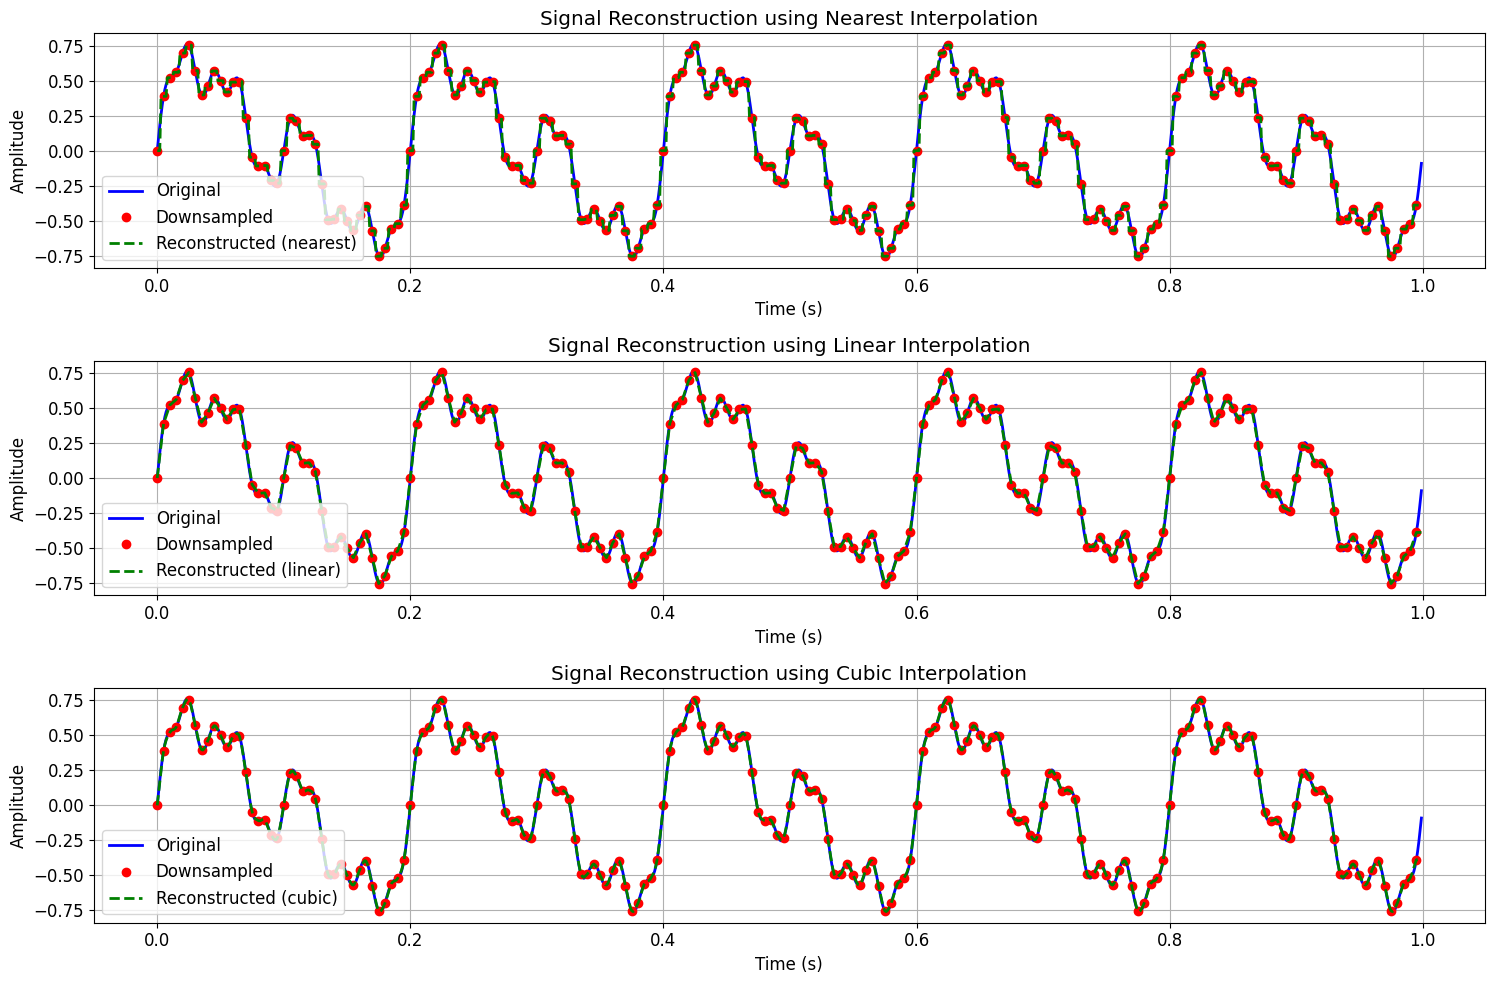

In [5]:
def reconstruct_signal(t_original, t_down, x_down, method):
    """
    Reconstruct a signal using different interpolation methods.
    
    Parameters:
    -----------
    t_original : ndarray
        Original time vector (target for reconstruction)
    t_down : ndarray
        Time vector of the downsampled signal
    x_down : ndarray
        Downsampled signal values
    method : str
        Interpolation method ('nearest', 'linear', 'cubic')
        
    Returns:
    --------
    x_recon : ndarray
        Reconstructed signal values
    """
    if method == 'nearest':
        return nearest_neighbor_interpolation(t_down, x_down, t_original)
    elif method == 'linear':
        return linear_interpolation(t_down, x_down, t_original)
    elif method == 'cubic':
        return cubic_interpolation(t_down, x_down, t_original)
    else:
        raise ValueError("Method must be 'nearest', 'linear', or 'cubic'")

# Reconstruct the signal using different interpolation methods
methods = ['nearest', 'linear', 'cubic']
reconstructed_signals = {}

for method in methods:
    reconstructed_signals[method] = reconstruct_signal(t_original, t_down, x_down, method)

# Plot the original, downsampled, and reconstructed signals
plt.figure(figsize=(15, 10))
for i, method in enumerate(methods):
    plt.subplot(len(methods), 1, i+1)
    plt.plot(t_original, x_original, 'b-', label='Original')
    plt.plot(t_down, x_down, 'ro', label='Downsampled')
    plt.plot(t_original, reconstructed_signals[method], 'g--', label=f'Reconstructed ({method})')
    plt.title(f'Signal Reconstruction using {method.capitalize()} Interpolation')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Comparison with Library Functions

Let's compare our manual implementations with SciPy's interpolation functions.

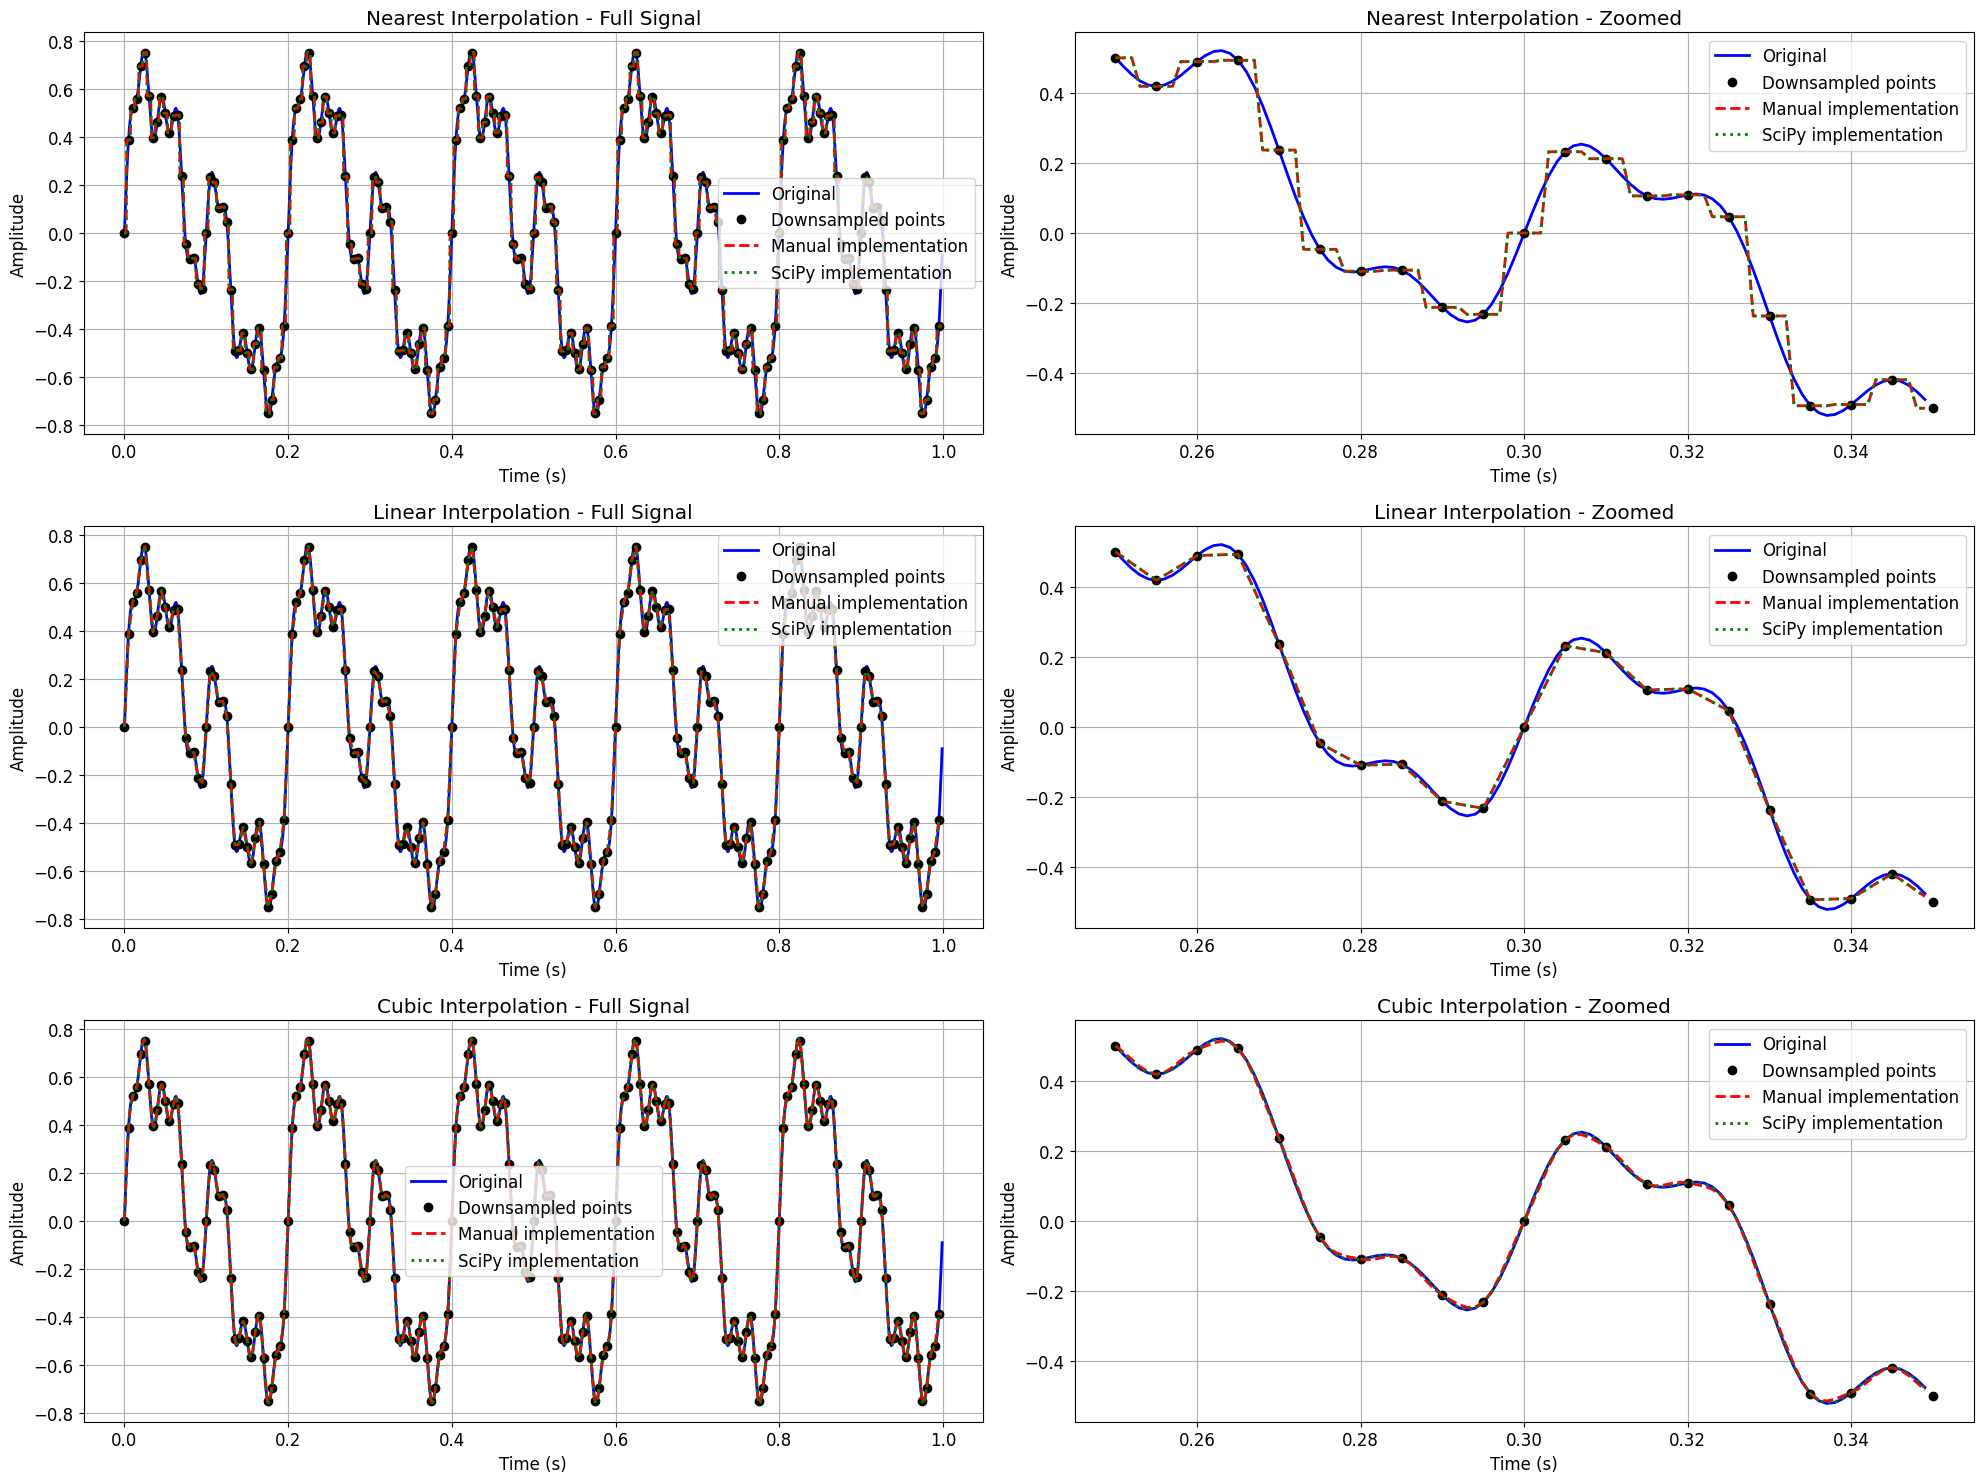

Nearest interpolation difference:
  Maximum absolute difference: 0.000000e+00
  Mean absolute difference: 0.000000e+00

Linear interpolation difference:
  Maximum absolute difference: 1.110223e-16
  Mean absolute difference: 2.217391e-18

Cubic interpolation difference:
  Maximum absolute difference: 2.669939e-02
  Mean absolute difference: 4.075530e-03



In [6]:
def scipy_interpolation(t_down, x_down, t_target, method):
    """
    Use scipy's interpolation functions.
    
    Parameters:
    -----------
    t_down : ndarray
        Time vector of the downsampled signal
    x_down : ndarray
        Downsampled signal values
    t_target : ndarray
        Target time vector for interpolation
    method : str
        Interpolation method ('nearest', 'linear', 'cubic')
        
    Returns:
    --------
    x_interp : ndarray
        Interpolated signal values
    """
    if method == 'nearest':
        interp_func = interpolate.interp1d(t_down, x_down, kind='nearest', 
                                         bounds_error=False, fill_value=(x_down[0], x_down[-1]))
    elif method == 'linear':
        interp_func = interpolate.interp1d(t_down, x_down, kind='linear', 
                                         bounds_error=False, fill_value=(x_down[0], x_down[-1]))
    elif method == 'cubic':
        if len(t_down) < 4:  # Cubic requires at least 4 points
            interp_func = interpolate.interp1d(t_down, x_down, kind='linear', 
                                         bounds_error=False, fill_value=(x_down[0], x_down[-1]))
        else:
            interp_func = interpolate.interp1d(t_down, x_down, kind='cubic', 
                                         bounds_error=False, fill_value=(x_down[0], x_down[-1]))
    else:
        raise ValueError("Method must be 'nearest', 'linear', or 'cubic'")
    
    return interp_func(t_target)

# Compare our manual implementations with scipy
scipy_reconstructed = {}
for method in methods:
    scipy_reconstructed[method] = scipy_interpolation(t_down, x_down, t_original, method)

# Plot comparison
plt.figure(figsize=(20, 15))
for i, method in enumerate(methods):
    # Plot entire signal
    plt.subplot(len(methods), 2, 2*i+1)
    plt.plot(t_original, x_original, 'b-', label='Original')
    plt.plot(t_down, x_down, 'ko', markersize=6, label='Downsampled points')
    plt.plot(t_original, reconstructed_signals[method], 'r--', linewidth=2, label='Manual implementation')
    plt.plot(t_original, scipy_reconstructed[method], 'g:', linewidth=2, label='SciPy implementation')
    plt.title(f'{method.capitalize()} Interpolation - Full Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    # Plot zoomed section to see differences
    plt.subplot(len(methods), 2, 2*i+2)
    start_idx = len(t_original) // 4
    end_idx = start_idx + len(t_original) // 10
    plt.plot(t_original[start_idx:end_idx], x_original[start_idx:end_idx], 'b-', label='Original')
    
    # Find downsampled points in the zoomed region
    mask = (t_down >= t_original[start_idx]) & (t_down <= t_original[end_idx])
    plt.plot(t_down[mask], x_down[mask], 'ko', markersize=6, label='Downsampled points')
    
    plt.plot(t_original[start_idx:end_idx], reconstructed_signals[method][start_idx:end_idx], 
             'r--', linewidth=2, label='Manual implementation')
    plt.plot(t_original[start_idx:end_idx], scipy_reconstructed[method][start_idx:end_idx], 
             'g:', linewidth=2, label='SciPy implementation')
    plt.title(f'{method.capitalize()} Interpolation - Zoomed')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate difference between manual and scipy implementations
for method in methods:
    diff = reconstructed_signals[method] - scipy_reconstructed[method]
    max_diff = np.max(np.abs(diff))
    mean_diff = np.mean(np.abs(diff))
    print(f"{method.capitalize()} interpolation difference:")
    print(f"  Maximum absolute difference: {max_diff:.6e}")
    print(f"  Mean absolute difference: {mean_diff:.6e}")
    print()

## 6. Error Analysis

Let's evaluate how well each interpolation method reconstructs the original signal by calculating the Root Mean Square Error (RMSE).

RMSE values for manual implementations:
  Nearest: 0.047788
  Linear: 0.020234
  Cubic: 0.013917

RMSE values for SciPy implementations:
  Nearest: 0.047788
  Linear: 0.020234
  Cubic: 0.012511



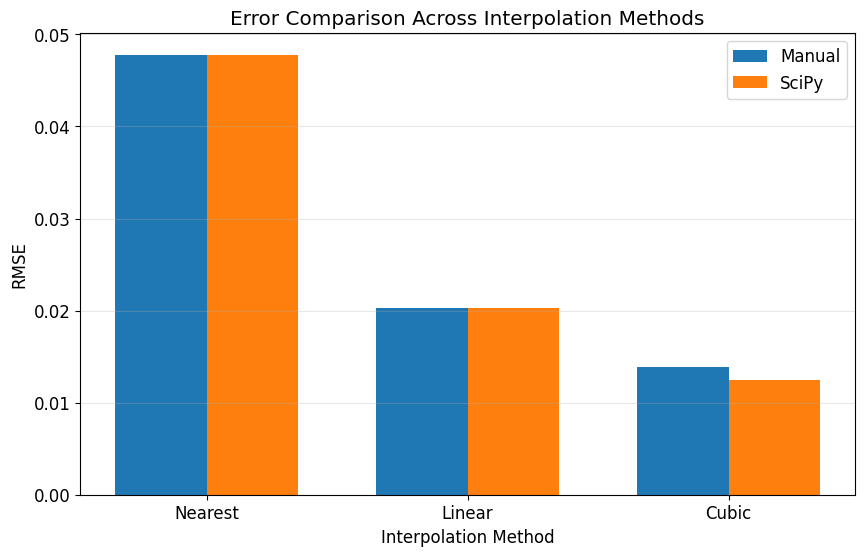

In [7]:
def calculate_rmse(original, reconstructed):
    """
    Calculate Root Mean Square Error between original and reconstructed signals.
    
    Parameters:
    -----------
    original : ndarray
        Original signal values
    reconstructed : ndarray
        Reconstructed signal values
        
    Returns:
    --------
    rmse : float
        Root Mean Square Error
    """
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# Calculate RMSE for each method
rmse_values = {}
for method in methods:
    rmse_values[method] = calculate_rmse(x_original, reconstructed_signals[method])

# Calculate RMSE for scipy implementations
scipy_rmse_values = {}
for method in methods:
    scipy_rmse_values[method] = calculate_rmse(x_original, scipy_reconstructed[method])

# Display RMSE values
print("RMSE values for manual implementations:")
for method in methods:
    print(f"  {method.capitalize()}: {rmse_values[method]:.6f}")
print()

print("RMSE values for SciPy implementations:")
for method in methods:
    print(f"  {method.capitalize()}: {scipy_rmse_values[method]:.6f}")
print()

# Plot RMSE values as bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, [rmse_values[method] for method in methods], width, label='Manual')
plt.bar(x + width/2, [scipy_rmse_values[method] for method in methods], width, label='SciPy')

plt.xlabel('Interpolation Method')
plt.ylabel('RMSE')
plt.title('Error Comparison Across Interpolation Methods')
plt.xticks(x, [method.capitalize() for method in methods])
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## 7. Frequency Domain Analysis

Now, let's analyze the original, downsampled, and reconstructed signals in the frequency domain.

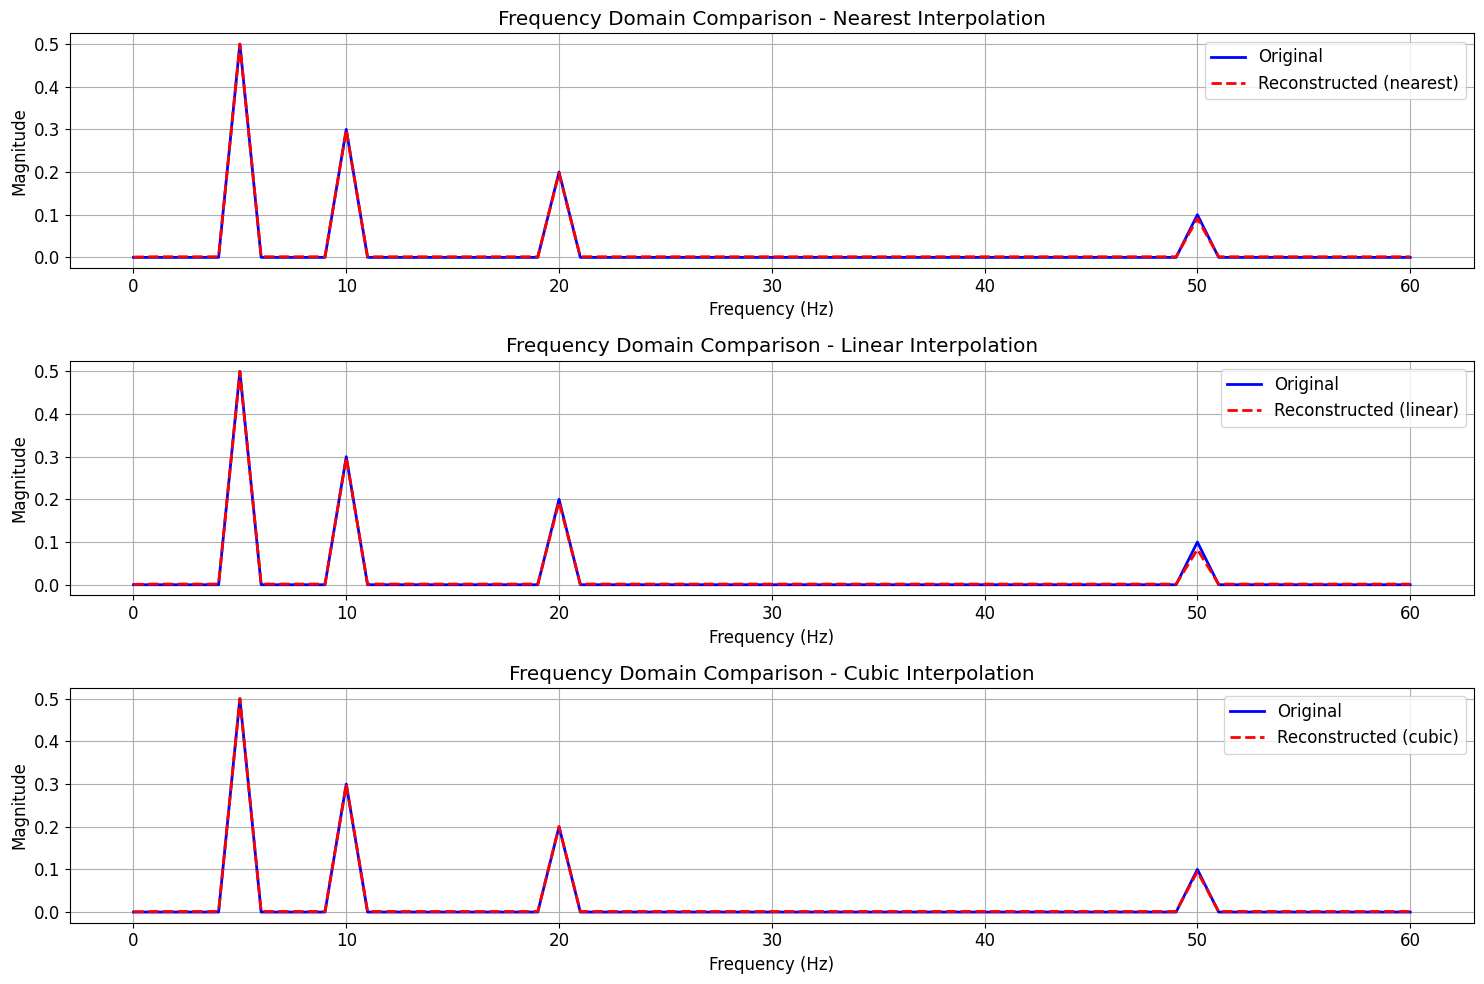

Frequency domain RMSE for nearest interpolation: 0.003019
Frequency domain RMSE for linear interpolation: 0.001272
Frequency domain RMSE for cubic interpolation: 0.000872


In [8]:
def calculate_fft(t, x):
    """
    Calculate the Fast Fourier Transform of a signal.
    
    Parameters:
    -----------
    t : ndarray
        Time vector
    x : ndarray
        Signal values
        
    Returns:
    --------
    freq : ndarray
        Frequency vector (Hz)
    magnitude : ndarray
        Magnitude spectrum (amplitude)
    """
    N = len(x)
    fs = 1 / (t[1] - t[0])  # Sampling frequency
    
    # Calculate FFT
    X = np.fft.fft(x)
    X_mag = np.abs(X) / N  # Normalize by the number of samples
    
    # Frequency vector
    freq = np.fft.fftfreq(N, 1/fs)
    
    # Only return the positive frequencies (the spectrum is symmetric for real signals)
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    X_mag = X_mag[pos_mask]
    
    # Scale all but the DC component by 2 to account for the negative frequencies
    X_mag[1:] = 2 * X_mag[1:]
    
    return freq, X_mag

# Calculate FFT for the original signal
freq_original, mag_original = calculate_fft(t_original, x_original)

# Calculate FFT for each reconstructed signal
freq_reconstructed = {}
mag_reconstructed = {}

for method in methods:
    freq_reconstructed[method], mag_reconstructed[method] = calculate_fft(t_original, reconstructed_signals[method])

# Plot frequency domain comparison
plt.figure(figsize=(15, 10))
for i, method in enumerate(methods):
    plt.subplot(len(methods), 1, i+1)
    
    # Plot up to 60 Hz for clarity
    freq_limit = 60
    mask_original = freq_original <= freq_limit
    mask_recon = freq_reconstructed[method] <= freq_limit
    
    plt.plot(freq_original[mask_original], mag_original[mask_original], 'b-', label='Original')
    plt.plot(freq_reconstructed[method][mask_recon], mag_reconstructed[method][mask_recon], 
             'r--', label=f'Reconstructed ({method})')
    
    plt.title(f'Frequency Domain Comparison - {method.capitalize()} Interpolation')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    
    # Add vertical line at Nyquist frequency
    nyquist = 1 / (t_down[1] - t_down[0]) / 2
    if nyquist <= freq_limit:
        plt.axvline(x=nyquist, color='g', linestyle='--', alpha=0.7, label='Nyquist frequency')
        plt.text(nyquist+1, plt.ylim()[1]*0.9, f'Nyquist: {nyquist:.1f} Hz', 
                 rotation=90, va='top', alpha=0.7)

plt.tight_layout()
plt.show()

# Calculate and display frequency domain error
for method in methods:
    # Since FFT frequencies might be different due to sampling rate differences, 
    # we'll compare only the original and reconstructed signals in the time domain
    freq_error = calculate_rmse(mag_original, mag_reconstructed[method])
    print(f"Frequency domain RMSE for {method} interpolation: {freq_error:.6f}")

## 8. Performance Analysis

Let's compare the computational performance of our manual implementations versus SciPy's functions.

Measuring execution times...
Execution times for manual implementations:
  Nearest: 6.644 ms
  Linear: 4.076 ms
  Cubic: 6.024 ms

Execution times for SciPy implementations:
  Nearest: 0.554 ms
  Linear: 0.102 ms
  Cubic: 0.376 ms



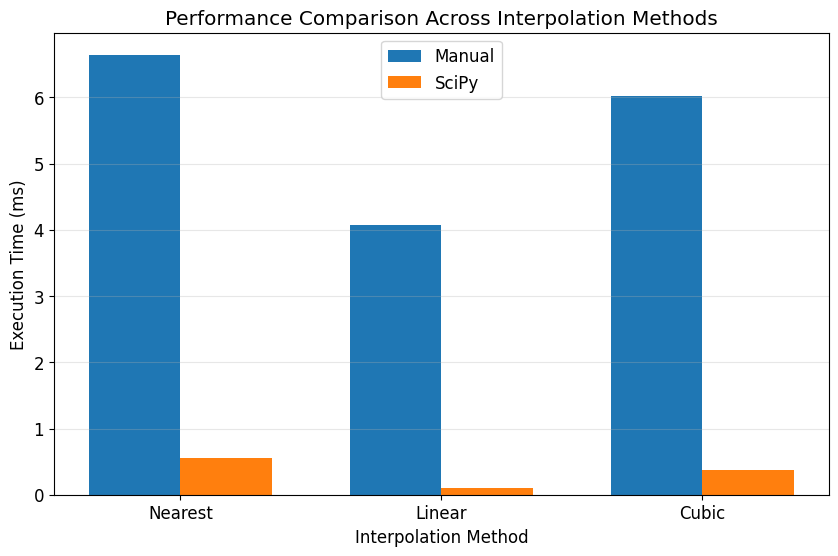

In [9]:
def measure_execution_time(func, *args, **kwargs):
    """
    Measure the execution time of a function.
    
    Parameters:
    -----------
    func : function
        Function to measure
    *args, **kwargs
        Arguments to pass to the function
        
    Returns:
    --------
    execution_time : float
        Execution time in milliseconds
    result
        Result of the function call
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    
    return (end_time - start_time) * 1000, result  # Convert to milliseconds

# Measure execution time for each interpolation method
manual_times = {}
scipy_times = {}

print("Measuring execution times...")
for method in methods:
    # Manual implementation
    if method == 'nearest':
        manual_times[method], _ = measure_execution_time(nearest_neighbor_interpolation, t_down, x_down, t_original)
    elif method == 'linear':
        manual_times[method], _ = measure_execution_time(linear_interpolation, t_down, x_down, t_original)
    elif method == 'cubic':
        manual_times[method], _ = measure_execution_time(cubic_interpolation, t_down, x_down, t_original)
    
    # SciPy implementation
    scipy_times[method], _ = measure_execution_time(scipy_interpolation, t_down, x_down, t_original, method)

# Display execution times
print("Execution times for manual implementations:")
for method in methods:
    print(f"  {method.capitalize()}: {manual_times[method]:.3f} ms")
print()

print("Execution times for SciPy implementations:")
for method in methods:
    print(f"  {method.capitalize()}: {scipy_times[method]:.3f} ms")
print()

# Plot execution times as bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, [manual_times[method] for method in methods], width, label='Manual')
plt.bar(x + width/2, [scipy_times[method] for method in methods], width, label='SciPy')

plt.xlabel('Interpolation Method')
plt.ylabel('Execution Time (ms)')
plt.title('Performance Comparison Across Interpolation Methods')
plt.xticks(x, [method.capitalize() for method in methods])
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## 9. Testing with Different Signals

Now let's test our interpolation methods on a variety of signals to see how they perform with different waveforms.

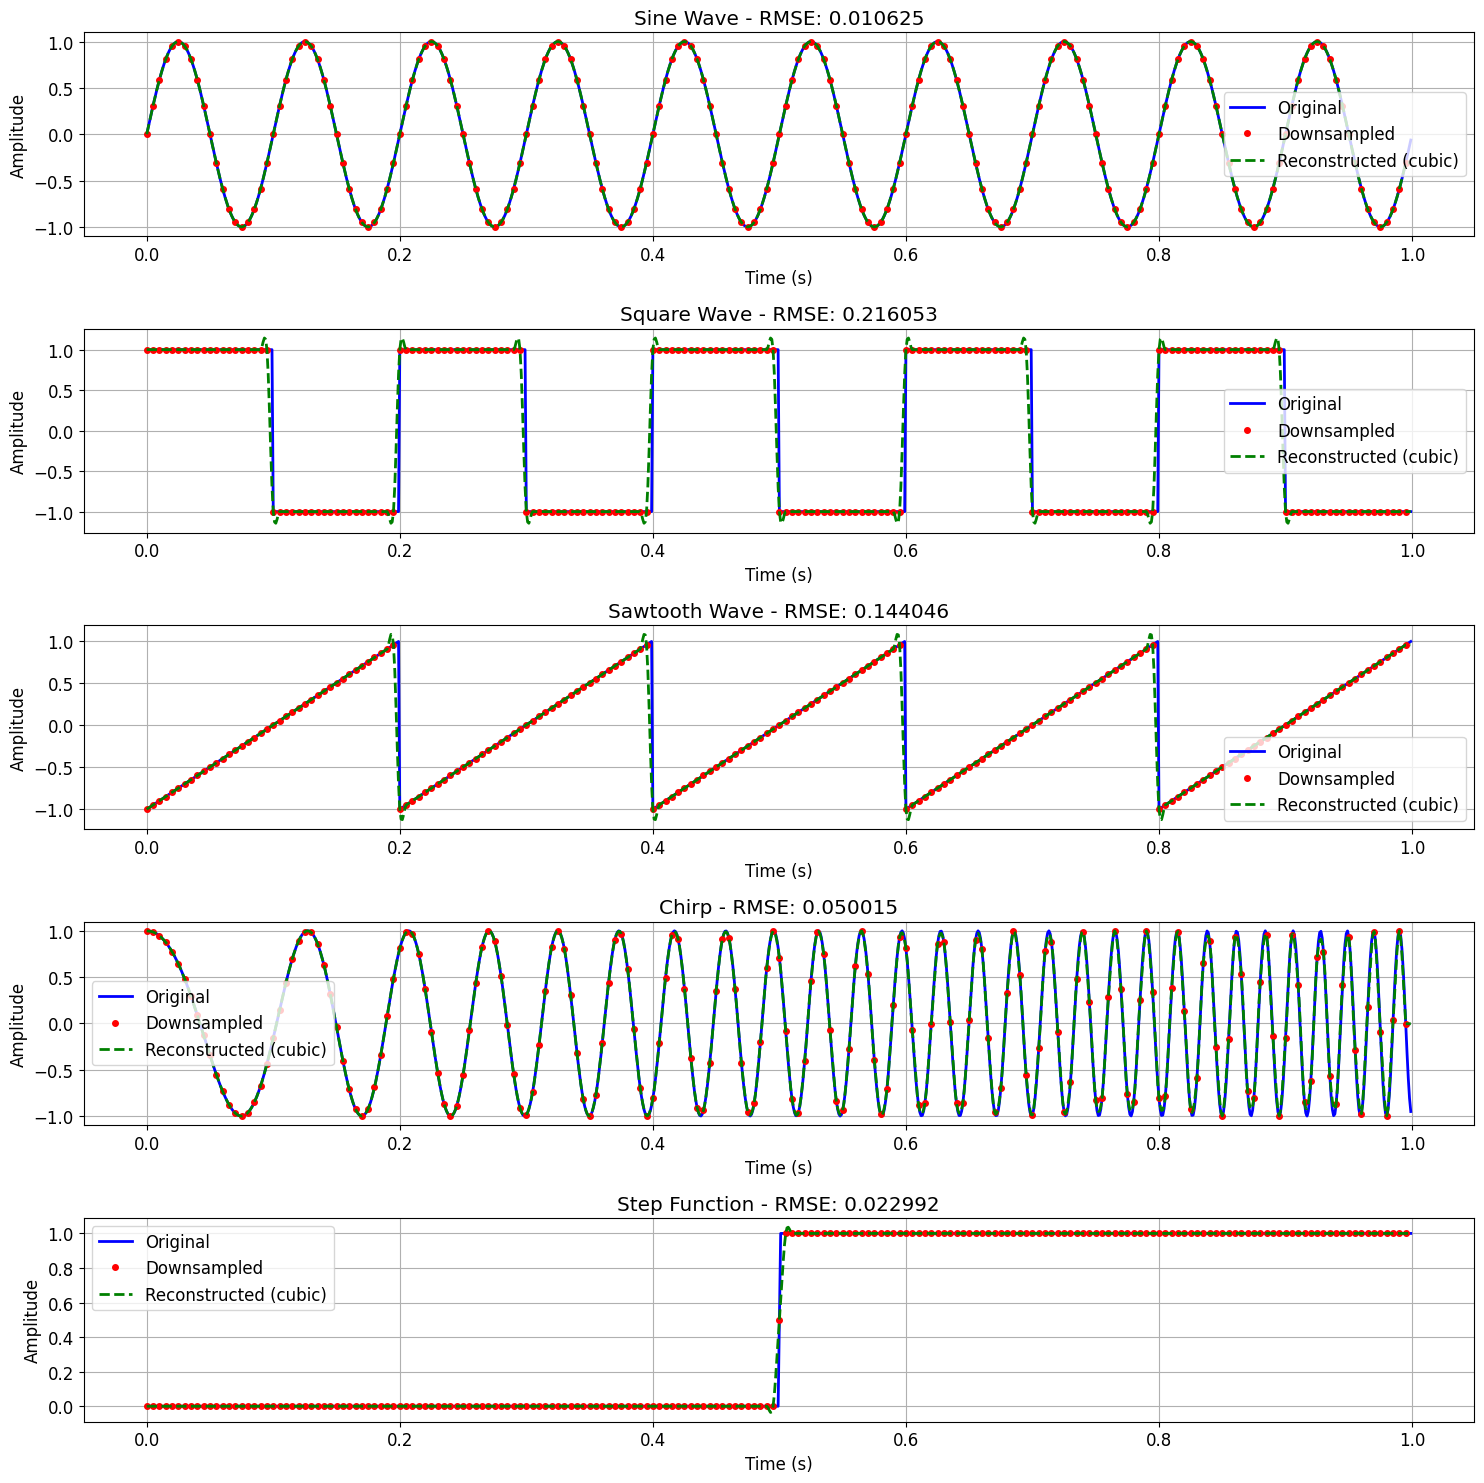

RMSE for different signal types using cubic interpolation:
  Sine Wave:
    Nearest: 0.063389
    Linear: 0.012375
    Cubic: 0.010625
  Square Wave:
    Nearest: 0.268328
    Linear: 0.207846
    Cubic: 0.216053
  Sawtooth Wave:
    Nearest: 0.178107
    Linear: 0.138575
    Cubic: 0.144046
  Chirp:
    Nearest: 0.193442
    Linear: 0.084163
    Cubic: 0.050015
  Step Function:
    Nearest: 0.031623
    Linear: 0.024495
    Cubic: 0.022992


In [10]:
# Generate a library of test signals
signal_library = generate_signal_library()

# Choose one interpolation method for demonstration
test_method = 'cubic'

# Downsample and reconstruct each signal
plt.figure(figsize=(15, 15))
for i, (signal_name, signal_data) in enumerate(signal_library.items()):
    # Extract signal data
    t_signal = signal_data['t']
    x_signal = signal_data['x']
    
    # Downsample
    t_down_signal, x_down_signal = downsample_signal(t_signal, x_signal, chosen_factor)
    
    # Reconstruct using manual implementation
    x_recon_signal = reconstruct_signal(t_signal, t_down_signal, x_down_signal, test_method)
    
    # Calculate RMSE
    rmse = calculate_rmse(x_signal, x_recon_signal)
    
    # Plot
    plt.subplot(len(signal_library), 1, i+1)
    plt.plot(t_signal, x_signal, 'b-', label='Original')
    plt.plot(t_down_signal, x_down_signal, 'ro', markersize=4, label='Downsampled')
    plt.plot(t_signal, x_recon_signal, 'g--', label=f'Reconstructed ({test_method})')
    plt.title(f'{signal_name} - RMSE: {rmse:.6f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Compute and display RMSE for each signal and method
print(f"RMSE for different signal types using {test_method} interpolation:")
for signal_name, signal_data in signal_library.items():
    # Extract signal data
    t_signal = signal_data['t']
    x_signal = signal_data['x']
    
    # Downsample
    t_down_signal, x_down_signal = downsample_signal(t_signal, x_signal, chosen_factor)
    
    # Calculate RMSE for each method
    rmse_values = {}
    for method in methods:
        x_recon = reconstruct_signal(t_signal, t_down_signal, x_down_signal, method)
        rmse_values[method] = calculate_rmse(x_signal, x_recon)
    
    print(f"  {signal_name}:")
    for method in methods:
        print(f"    {method.capitalize()}: {rmse_values[method]:.6f}")

## 10. Summary and Conclusions

In this notebook, we have implemented and analyzed various signal interpolation methods:

1. **Manual Implementations**:
   - Nearest Neighbor Interpolation
   - Linear Interpolation
   - Cubic Interpolation (using Hermite splines)

2. **Comparison with SciPy**:
   - Evaluated accuracy differences between manual and library implementations
   - Analyzed performance in terms of execution time

3. **Error Analysis**:
   - Calculated Root Mean Square Error (RMSE) for each method
   - Analyzed frequency domain characteristics
   - Tested on various signal types

### Key Findings:

1. **Interpolation Quality**:
   - Nearest neighbor interpolation produces the most discontinuous results but is the fastest
   - Linear interpolation offers a good balance between smoothness and computational complexity
   - Cubic interpolation produces the smoothest results but requires more computation

2. **Signal Type Impact**:
   - Smooth signals (sine waves) are easier to reconstruct accurately
   - Discontinuous signals (square waves, step functions) are more challenging
   - Higher frequency components require higher sampling rates to reconstruct accurately

3. **Performance Tradeoffs**:
   - Manual implementations provide educational value and flexibility
   - Library implementations (SciPy) are typically faster and more numerically stable
   - The choice of interpolation method depends on the specific application requirements

### Practical Applications:

These interpolation techniques are fundamental to many signal processing applications:
- Audio and image processing
- Medical signal analysis
- Data resampling and reconstruction
- Feature extraction in machine learning

By implementing these methods manually, we've gained insights into their inner workings, strengths, and limitations.